# Test du HSJ sur différents modèles

Import des librairies

In [1]:
import sys
import os

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

import numpy as np
import torch

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.logger import SimpleLogger

from art.attacks.evasion import HopSkipJump
from art.estimators.classification import SklearnClassifier, PyTorchClassifier

from NIDS_attacks.bounds_constrains import apply_bounds_constraints
from NIDS_attacks.integers_constrains import apply_integer_constraints

from scripts.models.decision_tree.decision_tree import train_decision_tree
from scripts.models.random_forest.random_forest import train_random_forest
from scripts.models.knn.knn import train_knn

from scripts.analysis.model_analysis import perform_model_analysis

from NIDS_attacks.hsj_attack_generalized import hsj_attack_generalized

Import du dataset

In [2]:
ds = CICIDS2017().optimize_memory().encode()
#ds = UNSWNB15().optimize_memory().encode()
ds = ds.subset(size=10000, multi_class=False)
X_train, X_test, y_train, y_test = ds.split(test_size=0.2, apply_smote=True)

[INFO] Downloading dataset: sweety18/cicids2017-full-dataset
[INFO] Loading dataset into DataFrame
[DEBUG] /home/loup/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1/combine.csv
[INFO] Loading dataset into DataFrame
[DEBUG] /home/loup/.cache/kagglehub/datasets/sweety18/cicids2017-full-dataset/versions/1/combine.csv
[INFO] Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
[DEBUG] Cleaning column names
[INFO] Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
[DEBUG] Cleaning column names
[DEBUG] Removing duplicate rows
[DEBUG] Removing duplicate rows
[DEBUG] Removed 271,598 duplicate rows. Remaining: 1,942,871
[DEBUG] Removing rows with missing values (initial pass)
[DEBUG] Removed 271,598 duplicate rows. Remaining: 1,942,871
[DEBUG] Removing rows with missing values (initial pass)
[DEBUG] Removed 178 rows with missing values. Remaining: 1,942,693
[DEBUG] Checking for infinite values in numeric columns
[DEBUG] Removed 178 rows wit

Choix des contraintes

In [3]:
integer_indices = [0, 2, 5, 10, 15] # Exemple
modifiable_indices = list(range(20))

## 1.Decision Tree

In [ ]:
model_dt, _ = train_decision_tree(X_train, y_train, max_depth=15)

results_dt = hsj_attack_generalized(
        model=model_dt,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=1000,
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=False
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.994
[INFO] Attacking 1000 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1.]


HopSkipJump:   0%|          | 0/1000 [00:00<?, ?it/s]

[INFO] === Attack Results ===
[INFO] Original accuracy on attack samples: 0.995
[INFO] Adversarial accuracy on attack samples: 0.999
[INFO] Attack success rate (attacks -> benign): 0.001
[INFO] Average L2 perturbation: 0.194500
[INFO] Constraints applied: bounds + 5 integer features
[INFO] 
Summary: Attack succeeded 0.1% of the time


[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Original
[DEBUG] 
Classification Report for Decision Tree - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9911    0.9960    0.9935      1001
         1.0     0.9960    0.9910    0.9935       999

    accuracy                         0.9935      2000
   macro avg     0.9935    0.9935    0.9935      2000
weighted avg     0.9935    0.9935    0.9935      2000




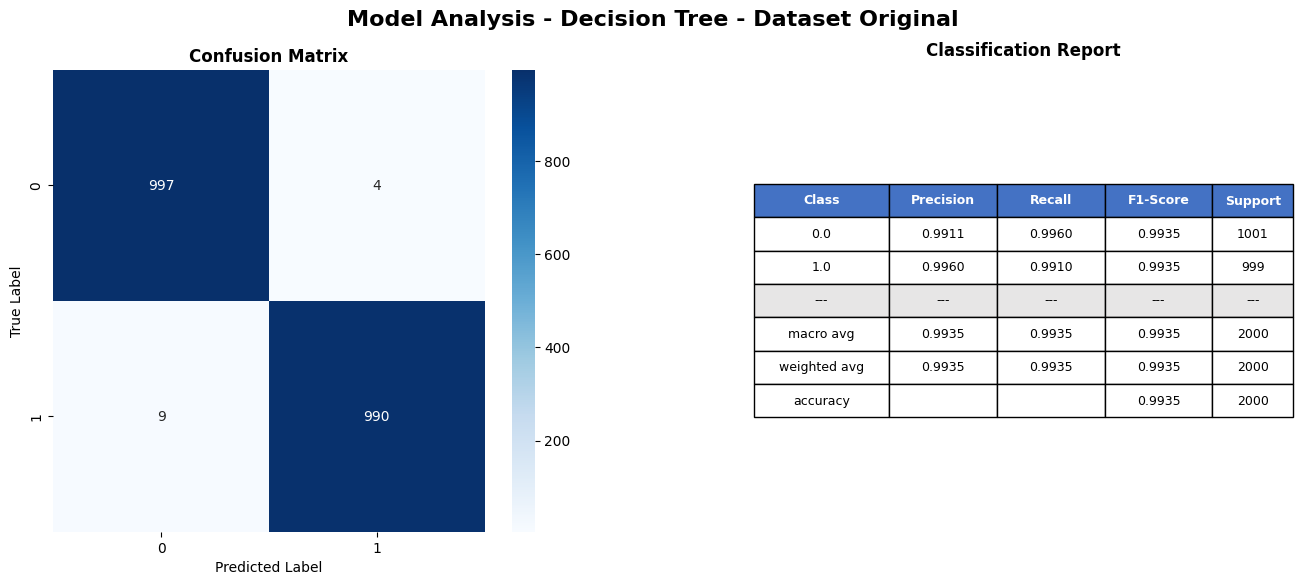

[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Original
[DEBUG] 
Classification Report for Decision Tree - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9911    0.9960    0.9935      1001
         1.0     0.9960    0.9910    0.9935       999

    accuracy                         0.9935      2000
   macro avg     0.9935    0.9935    0.9935      2000
weighted avg     0.9935    0.9935    0.9935      2000




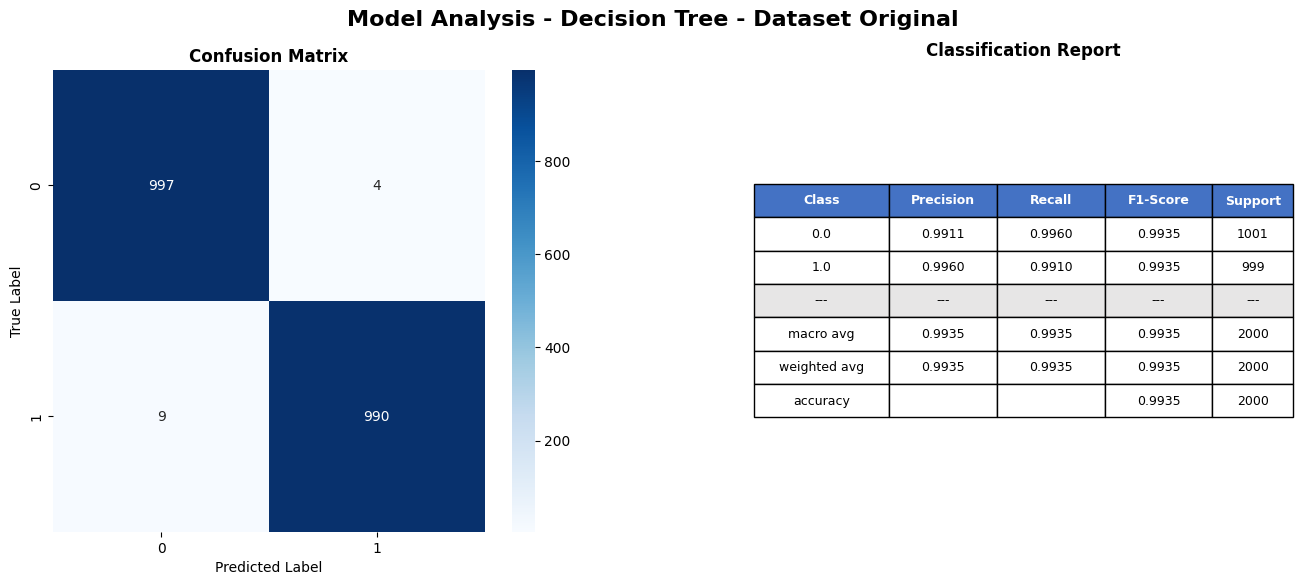

[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Adverserial
[DEBUG] 
Classification Report for Decision Tree - Dataset Adverserial
              precision    recall  f1-score   support

         0.0     0.5760    0.9960    0.7299      1001
         1.0     0.9851    0.2653    0.4180       999

    accuracy                         0.6310      2000
   macro avg     0.7805    0.6306    0.5739      2000
weighted avg     0.7803    0.6310    0.5741      2000




[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Original
[DEBUG] 
Classification Report for Decision Tree - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9911    0.9960    0.9935      1001
         1.0     0.9960    0.9910    0.9935       999

    accuracy                         0.9935      2000
   macro avg     0.9935    0.9935    0.9935      2000
weighted avg     0.9935    0.9935    0.9935      2000




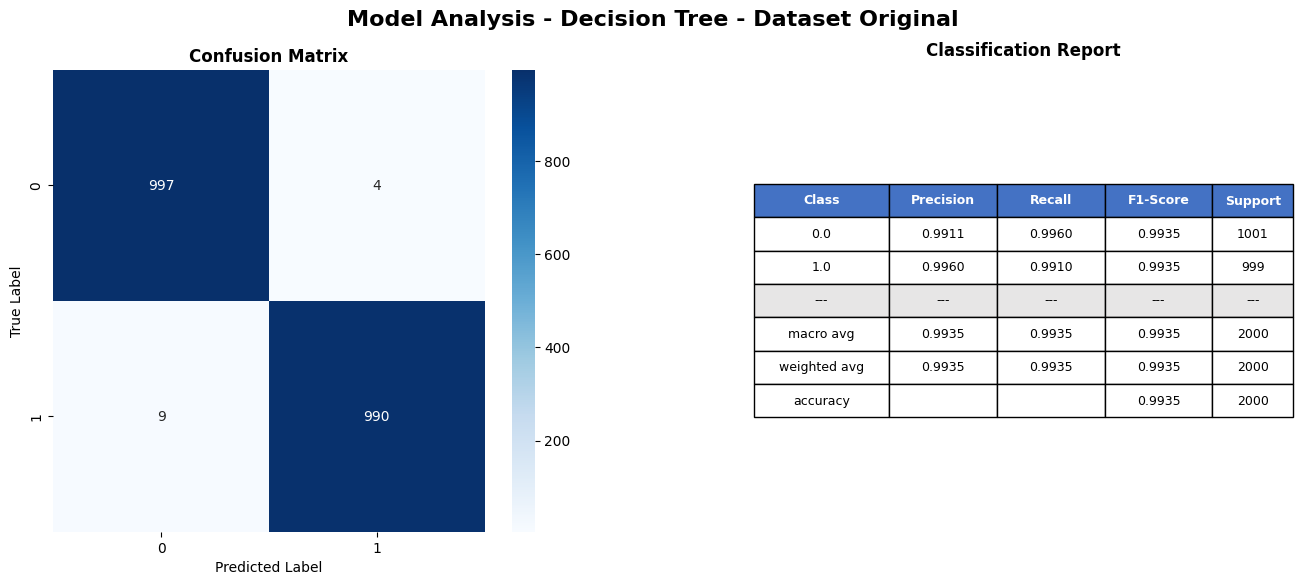

[INFO] Running analysis for scikit-learn model: Decision Tree - Dataset Adverserial
[DEBUG] 
Classification Report for Decision Tree - Dataset Adverserial
              precision    recall  f1-score   support

         0.0     0.5760    0.9960    0.7299      1001
         1.0     0.9851    0.2653    0.4180       999

    accuracy                         0.6310      2000
   macro avg     0.7805    0.6306    0.5739      2000
weighted avg     0.7803    0.6310    0.5741      2000




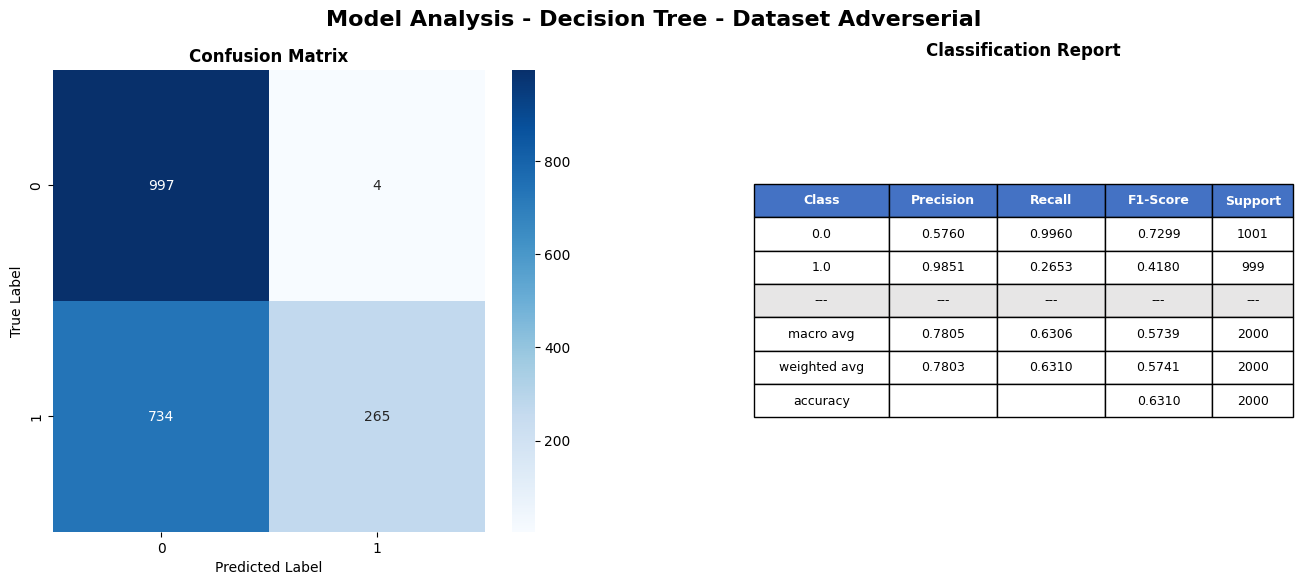

In [32]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_dt,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="Decision Tree - Dataset Original",
    plot=True,
    save_fig=False
)

# Create adversarial dataset by replacing original attack samples with adversarial ones
X_adverserial = X_test.copy()
attack_indices = np.where(results_dt['attack_indices'])[0]  # Convert boolean mask to indices
actual_attack_samples = attack_indices[:len(results_dt['X_adv'])]  # Only take indices for generated samples

for i, idx in enumerate(actual_attack_samples):
    X_adverserial[idx] = results_dt['X_adv'][i]

cm_adv, report_adv = perform_model_analysis(
    model=model_dt,
    X_test=X_adverserial,
    y_test=y_test,
    logger=logger,
    title="Decision Tree - Dataset Adverserial",
    plot=True,
    save_fig=False
)

## 2.Random Forest

In [6]:
model_rf, _ = train_random_forest(
    X_train,
    y_train,
    n_estimators=3,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=None,
    random_state=0,
    cv=5,
    class_weight=None,
    logger=None
)

results_rf = hsj_attack_generalized(
        model=model_rf,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=2000,
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=True
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.975
[INFO] Attacking 1009 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1.]


HopSkipJump:   0%|          | 0/1009 [00:00<?, ?it/s]

KeyboardInterrupt: 

[INFO] Running analysis for scikit-learn model: Random Forest - Dataset Original
[DEBUG] 
Classification Report for Random Forest - Dataset Original
              precision    recall  f1-score   support

         0.0     0.9846    0.9647    0.9745       991
         1.0     0.9660    0.9851    0.9755      1009

    accuracy                         0.9750      2000
   macro avg     0.9753    0.9749    0.9750      2000
weighted avg     0.9752    0.9750    0.9750      2000




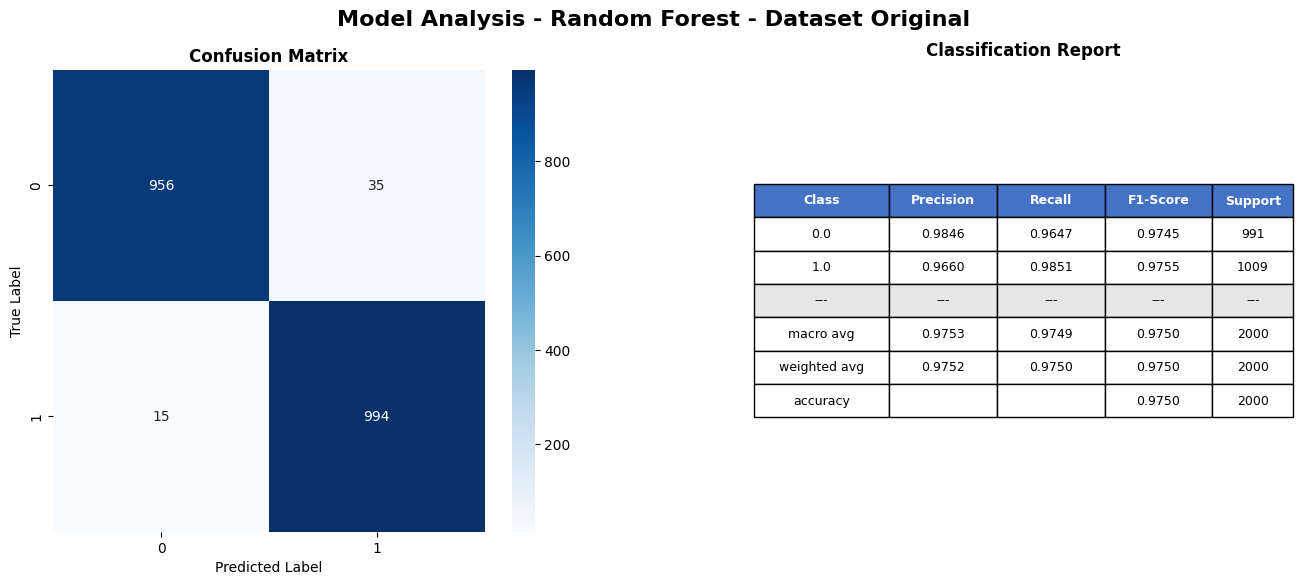

NameError: name 'results_rf' is not defined

In [7]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_rf,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="Random Forest - Dataset Original",
    plot=True,
    save_fig=False
)

# Create adversarial dataset by replacing original attack samples with adversarial ones
X_adverserial_rf = X_test.copy()
attack_indices = np.where(results_rf['attack_indices'])[0]  # Convert boolean mask to indices
actual_attack_samples = attack_indices[:len(results_rf['X_adv'])]  # Only take indices for generated samples

for i, idx in enumerate(actual_attack_samples):
    X_adverserial_rf[idx] = results_rf['X_adv'][i]

cm_adv, report_adv = perform_model_analysis(
    model=model_rf,
    X_test=X_adverserial_rf,
    y_test=y_test,
    logger=logger,
    title="Random Forest - Dataset Adverserial",
    plot=True,
    save_fig=False
)

## 3.KNN

In [ ]:
model_knn, _ = train_knn(X_train, y_train, n_neighbors=5)

results_knn = hsj_attack_generalized(
        model=model_knn,
        X_test=X_test,
        y_test=y_test,
        dataset="CICIDS2017",
        #dataset="UNSWNB15",
        nb_samples=100,
        integer_indices=integer_indices,
        modifiable_indices=modifiable_indices,
        apply_constraints=True,
        per_sample_visualization=True
    )

[INFO] Starting Generalized HopSkipJump attack on CICIDS2017
[INFO] Using targeted class: 0
[INFO] Applying constraints with 20 modifiable features
[INFO] Integer constraints on 5 features
[INFO] Initial accuracy: 0.949
[INFO] Attacking 10 attack samples to make them appear benign...
[INFO] Target classes being attacked: [1. 2. 3.]


HopSkipJump:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
logger = SimpleLogger()
cm_orig, report_orig = perform_model_analysis(
    model=model_knn,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="K-Nearest Neighbors - Dataset Original",
    plot=True,
    save_fig=False
)

cm_adv, report_adv = perform_model_analysis(
    model=model_knn,
    X_test=results_knn['X_adv'],
    y_test=results_knn['y_attacks'],
    logger=logger,
    title="K-Nearest Neighbors - Dataset Adverserial",
    plot=True,
    save_fig=False
)